 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.autograd import Variable
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import torch.nn.functional as F

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

fashion_type = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat", 
  5: "Sandal", 
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

## Смотрим на датасет

In [ ]:
print("Images in train:", len(trainset))
print("Images in test: ", len(testset))

Images in train: 60000
Images in test:  10000


In [ ]:
train_unique = trainset.targets.unique(return_counts=True)[1]
test_unique = testset.targets.unique(return_counts=True)[1]

In [ ]:
print("Is it evenly distributed in the test:", (torch.mean(test_unique[0].float()) == test_unique[0]).item())
print("Is it evenly distributed in the train:", (torch.mean(train_unique[0].float()) == train_unique[0]).item())

Is it evenly distributed in the test: True
Is it evenly distributed in the train: True


T-shirt/top


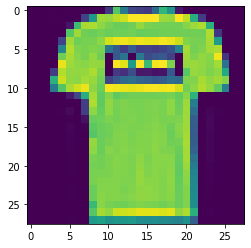

Bag


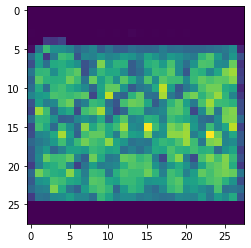

Trouser


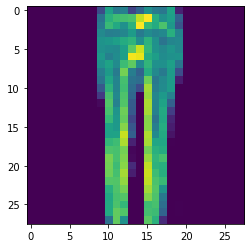

Pullover


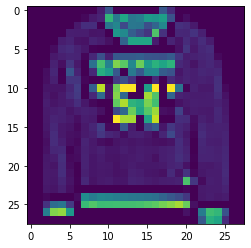

In [ ]:
for i in [1, 23, 456, 7890]:
  print(fashion_type[trainset.targets[i].item()])
  plt.imshow(trainset.data[i])
  plt.show()

In [ ]:
def fit(model, optimizer, loss_fn, epochs = 10):
  loss_values = []
  for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(trainloader):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      optimizer.zero_grad()
      loss = loss_fn(model(images), labels)
      loss.backward()
      optimizer.step()
      if(i == 1000):
        loss_values.append(loss.detach().cpu().item())
  plt.plot(loss_values)
  plt.show()

In [ ]:
def report(model, testloader):  
  model.eval()
  y_trues = list()
  y_hats = list()
  with torch.no_grad():
    for batch in testloader:
      y_pred = model(batch[0].cuda())
      y_hat = torch.argmax(y_pred, dim=1).detach().cpu()
      y_trues.extend(batch[1])
      y_hats.extend(y_hat)
  print(classification_report(y_hats, y_trues))

Чтобы было не скучно, решил протестировать методы на различных гиперпараметрах и методов оптимизации, и сравним их друг с другом

## MLP

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(MLP, self).__init__()
    self.first_layer = torch.nn.Linear(D_in, H[0])
    self.first_ReLu = torch.nn.ReLU()
    self.second_layer = torch.nn.Linear(H[0], H[1])
    self.second_ReLu = torch.nn.ReLU()
    self.third_layer = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = x.view(-1, 784)
    x = self.first_layer(x)
    x = self.first_ReLu(x)
    x = self.second_layer(x)
    x = self.second_ReLu(x)
    x = self.third_layer(x)
    return x

### MLP(784, [**256**, 128], 10) SGD

In [ ]:
model = MLP(784, [256, 128], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/10 [00:00<?, ?it/s]

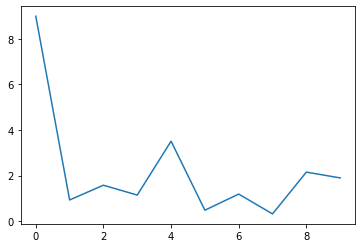

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1046
           1       0.96      0.98      0.97       982
           2       0.76      0.77      0.76       983
           3       0.85      0.87      0.86       980
           4       0.80      0.74      0.77      1075
           5       0.92      0.96      0.94       956
           6       0.62      0.68      0.65       923
           7       0.95      0.89      0.92      1070
           8       0.96      0.96      0.96      1003
           9       0.94      0.95      0.94       982

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### MLP(784, [256, 128], 10) Adam

In [ ]:
model = MLP(784, [256, 128], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/10 [00:00<?, ?it/s]

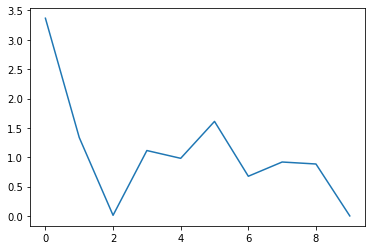

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1041
           1       0.97      0.99      0.98       983
           2       0.77      0.80      0.79       960
           3       0.89      0.90      0.89       989
           4       0.90      0.71      0.79      1270
           5       0.97      0.97      0.97       998
           6       0.61      0.80      0.70       762
           7       0.94      0.96      0.95       978
           8       0.97      0.98      0.97       988
           9       0.98      0.95      0.96      1031

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### MLP(784, [128, 64], 10) SGD

In [ ]:
model = MLP(784, [128, 64], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/10 [00:00<?, ?it/s]

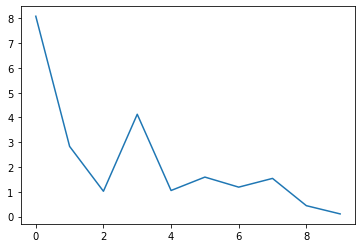

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1031
           1       0.96      0.98      0.97       972
           2       0.82      0.71      0.76      1154
           3       0.88      0.82      0.85      1065
           4       0.76      0.76      0.76      1003
           5       0.92      0.95      0.94       975
           6       0.55      0.73      0.63       756
           7       0.95      0.90      0.92      1061
           8       0.95      0.95      0.95      1007
           9       0.93      0.95      0.94       976

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### MLP(784, [128, 64], 10) Adam

In [ ]:
model = MLP(784, [128, 64], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/10 [00:00<?, ?it/s]

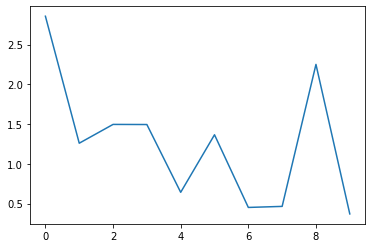

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       910
           1       0.95      1.00      0.97       958
           2       0.81      0.81      0.81      1003
           3       0.90      0.89      0.89      1010
           4       0.82      0.81      0.82      1005
           5       0.96      0.97      0.97       994
           6       0.76      0.68      0.72      1109
           7       0.96      0.94      0.95      1031
           8       0.97      0.97      0.97       999
           9       0.95      0.97      0.96       981

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### Вывод

MLP хорошо показывет себя если воспосользоваться Adam`ом в качестве метода оптимизации (стабильные 0.89), но SGD тоже выдает неплохие результаты (0.85 - 0.86).

## CNN

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(CNN, self).__init__()
    self.first_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.second_conv = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.first_layer = torch.nn.Linear(D_in, H[0])
    self.second_layer = torch.nn.Linear(H[0], H[1])
    self.third_layer = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = self.pool(F.relu(self.first_conv(x)))
    x = self.pool(F.relu(self.second_conv(x)))
    x = x.view(-1, 4 * 4 * 16)
    x = F.relu(self.first_layer(x))
    x = F.relu(self.second_layer(x))
    x = self.third_layer(x)
    return x

### CNN(256, [256, 128], 10) SGD

In [ ]:
model = CNN(4 * 4 * 16, [256, 128], 10) #Воспользовался лайфхаком из "practice 7 convnet mnist"

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

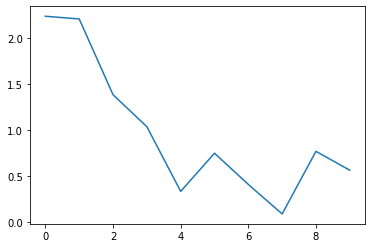

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1217
           1       0.93      0.95      0.94       974
           2       0.64      0.58      0.61      1107
           3       0.82      0.80      0.81      1036
           4       0.66      0.65      0.65      1003
           5       0.91      0.91      0.91      1006
           6       0.30      0.47      0.37       645
           7       0.79      0.92      0.85       862
           8       0.92      0.93      0.92       983
           9       0.97      0.83      0.90      1167

    accuracy                           0.78     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.80      0.78      0.78     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### CNN(256, [256, 128], 10) Adam

In [ ]:
model = CNN(4 * 4 * 16, [256, 128], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

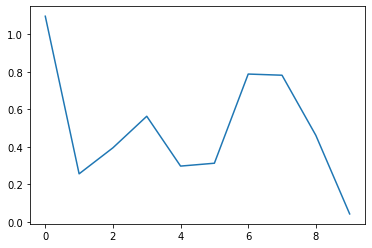

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1141
           1       0.98      0.99      0.99       983
           2       0.88      0.79      0.84      1112
           3       0.94      0.86      0.90      1083
           4       0.82      0.83      0.82       989
           5       0.95      0.99      0.97       966
           6       0.56      0.83      0.67       677
           7       0.98      0.91      0.95      1077
           8       0.97      0.97      0.97      1006
           9       0.94      0.98      0.96       966

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### CNN(256, [128, 64], 10) SGD

In [ ]:
model = CNN(4 * 4 * 16, [128, 64], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

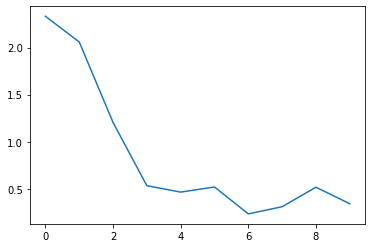

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1005
           1       0.94      0.96      0.95       979
           2       0.44      0.69      0.54       630
           3       0.83      0.76      0.79      1091
           4       0.85      0.51      0.64      1668
           5       0.91      0.90      0.90      1008
           6       0.26      0.43      0.32       604
           7       0.90      0.88      0.89      1024
           8       0.91      0.92      0.92       996
           9       0.92      0.92      0.92       995

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.81      0.77      0.78     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### CNN(256, [128, 64], 10) Adam

In [ ]:
model = CNN(4 * 4 * 16, [128, 64], 10)

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/10 [00:00<?, ?it/s]

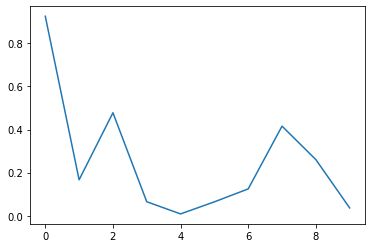

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       883
           1       0.97      0.99      0.98       974
           2       0.88      0.78      0.83      1127
           3       0.91      0.88      0.90      1031
           4       0.81      0.82      0.81       976
           5       0.96      0.98      0.97       985
           6       0.72      0.72      0.72      1001
           7       0.96      0.94      0.95      1016
           8       0.97      0.97      0.97      1001
           9       0.96      0.96      0.96      1006

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
fit(model, optimizer, loss_fn)
report(model, testloader)

### Вывод

На CNN SGD показался неэффективным (выдает в диапазоне 0.77 - 0.78), возможно это связанно с набором гиперпараметров, но на Adam'е при таких же гиперпараметрах результат 0.89

## Вывод

Если смотреть по показателям accuracy и по графикам, то лучше всего показал себя CNN, на графиках скачки минальны и виден четкий "спуск"